In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from utils import expected_calibration_error, permutation_test_ause
# from bayesian_model import GPSparseBayesModel
import seaborn as sns
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier

from utils import return_replicates, ause
from utils import permutation_test_ause

Diabetes

In [4]:
def get_ece(pred_probs, true_labels):
    pred_probs_t = np.reshape(pred_probs, (-1,1))
    pred_ece = expected_calibration_error(true_labels, np.concatenate((1-pred_probs_t, pred_probs_t), axis=1), num_bins=12)
    return pred_ece

In [5]:
diabetes_df = pd.read_csv("data/diabetes.csv")

diabetes_ood = diabetes_df.loc[diabetes_df['Age']>45]
diabetes_id = diabetes_df.loc[diabetes_df['Age']<=45]

X_train, y_train = diabetes_id[["Pregnancies", "Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age"]], diabetes_id[['Outcome']]
X_test, y_test = diabetes_ood[["Pregnancies", "Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age"]], diabetes_ood[['Outcome']]

X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train).ravel(), np.array(y_test).ravel()

Accuracy: 0.5932203389830508 F1 Score: 0.6521739130434782 ECE: 0.11605920317638395


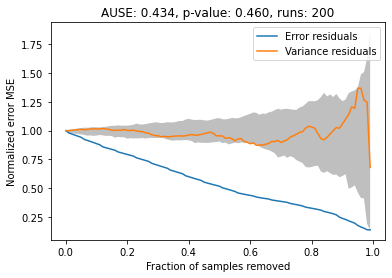

In [128]:
kernel = 'rbf'
loss = 'trace_meanfield_elbo'
induced_points_method = 'random'

model = SVC()

model.after_setup()
model.train(X_train, y_train)
pred_probs, pred_vars, pred_labels = model.test(X_test, None)
print("Accuracy:", accuracy_score(y_test, pred_labels), 
      "F1 Score:", f1_score(y_test, pred_labels), 
      "ECE:", get_ece(pred_probs, y_test))
permutation_test_ause(pred_probs, pred_vars, y_test)

Accuracy: 0.5847457627118644 F1 Score: 0.6797385620915034 ECE: 0.0932015827070266


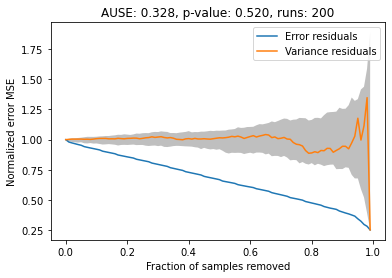

In [17]:
n_estimator=20
max_sample=0.8

pipeline = Pipeline([('scale', StandardScaler()), ('svc', SVC(probability=True))])
model = BaggingClassifier(base_estimator=pipeline, n_estimators=n_estimator, max_samples=max_sample)

model.fit(X_train, y_train)

y_preds = model.predict(X_test)
y_probs = model.predict_proba(X_test)

probs = pd.DataFrame()
i = 1
for mod in model.estimators_:
    probs1 = mod.predict_proba(X_test)[:, 1] # probabilities of input being classified as 1
    probs[f'mod{i}'] = probs1
    i+=1

var_predictions = probs.var(axis=1).ravel()

accuracy = accuracy_score(y_test, y_preds)
f1 = f1_score(y_test,y_preds)
ece = expected_calibration_error(y_test, y_probs)
pred_ause = ause(y_probs[:,1].ravel(), var_predictions, y_test.ravel())[0]

print("Accuracy:", accuracy, 
      "F1 Score:", f1, 
      "ECE:", ece)
permutation_test_ause(y_probs[:,1].ravel(), var_predictions, y_test.ravel())

Red wine

In [18]:
r_wine = pd.read_csv('data/winequality-red.csv', sep=";")
r_wine_s = r_wine.sort_values(by='quality')

r_wine_ood = r_wine_s[800:1000]
r_wine_id = r_wine_s.drop(range(800,1000,1))

r_wine_id['label'] = r_wine_id['quality'] > 5
r_wine_id['label'] = r_wine_id['label'].astype(int)

r_wine_ood['label'] = r_wine_ood['quality'] > 5
r_wine_ood['label'] = r_wine_ood['label'].astype(int)

C:\Users\ADMIN\AppData\Local\Temp/ipykernel_21848/618528233.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_wine_ood['label'] = r_wine_ood['quality'] > 5
C:\Users\ADMIN\AppData\Local\Temp/ipykernel_21848/618528233.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_wine_ood['label'] = r_wine_ood['label'].astype(int)


In [19]:
X_train, y_train = r_wine_id[r_wine_id.columns[:-2]], r_wine_id['label']
X_test, y_test = r_wine_ood[r_wine_ood.columns[:-2]], r_wine_ood['label']
X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train).ravel(), np.array(y_test).ravel()

Accuracy: 0.775 F1 Score: 0.8732394366197184


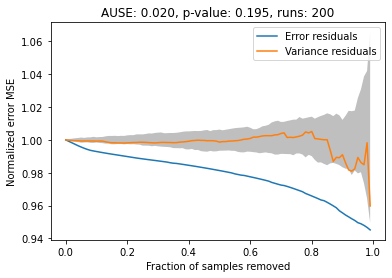

In [65]:
kernel = 'poly'
loss = 'trace_meanfield_elbo'
induced_points_method = 'random'

model = GPSparseBayesModel(**{"random_seed": 7200, 
                              "num_induced_samples": 'sqrt', 
                              "kernel": kernel,
                              "loss": loss,
                              "induced_points_method": induced_points_method
                            })
model.after_setup()
model.train(X_train, y_train)
pred_probs, pred_vars, pred_labels = model.test(X_test, None)
print("Accuracy:", accuracy_score(y_test, pred_labels), "F1 Score:", f1_score(y_test, pred_labels))
permutation_test_ause(pred_probs, pred_vars, y_test)

Accuracy: 0.805 F1 Score: 0.89196675900277 ECE: 0.046665529516309076


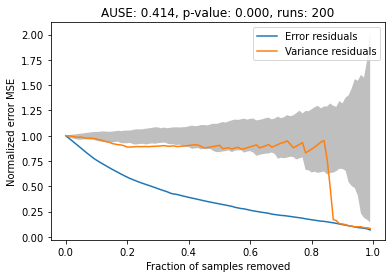

In [21]:
n_estimator=20
max_sample=1.0

pipeline = Pipeline([('scale', StandardScaler()), ('svc', SVC(probability=True))])
model = BaggingClassifier(base_estimator=pipeline, n_estimators=n_estimator, max_samples=max_sample)

model.fit(X_train, y_train)

y_preds = model.predict(X_test)
y_probs = model.predict_proba(X_test)

probs = pd.DataFrame()
i = 1
for mod in model.estimators_:
    probs1 = mod.predict_proba(X_test)[:, 1] # probabilities of input being classified as 1
    probs[f'mod{i}'] = probs1
    i+=1

var_predictions = probs.var(axis=1).ravel()

accuracy = accuracy_score(y_test, y_preds)
f1 = f1_score(y_test,y_preds)
ece = expected_calibration_error(y_test, y_probs)
pred_ause = ause(y_probs[:,1].ravel(), var_predictions, y_test.ravel())[0]

print("Accuracy:", accuracy, 
      "F1 Score:", f1, 
      "ECE:", ece)
permutation_test_ause(y_probs[:,1].ravel(), var_predictions, y_test.ravel())

White wine

In [22]:
w_wine = pd.read_csv('data/winequality-white.csv', sep=";")
w_wine_s = w_wine.sort_values(by='alcohol')

w_wine_ood = w_wine_s[2000:2800]
w_wine_id = w_wine_s.drop(range(2000,2800,1))

w_wine_id['label'] = w_wine_id['quality'] > 5
w_wine_id['label'] = w_wine_id['label'].astype(int)

w_wine_ood['label'] = w_wine_ood['quality'] > 5
w_wine_ood['label'] = w_wine_ood['label'].astype(int)

X_train, y_train = w_wine_id[w_wine_id.columns[:-2]], w_wine_id['label']
X_test, y_test = w_wine_ood[w_wine_ood.columns[:-2]], w_wine_ood['label']
X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train).ravel(), np.array(y_test).ravel()

C:\Users\ADMIN\AppData\Local\Temp/ipykernel_21848/1235782557.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w_wine_ood['label'] = w_wine_ood['quality'] > 5
C:\Users\ADMIN\AppData\Local\Temp/ipykernel_21848/1235782557.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w_wine_ood['label'] = w_wine_ood['label'].astype(int)


Accuracy: 0.68375 F1 Score: 0.797113071371291


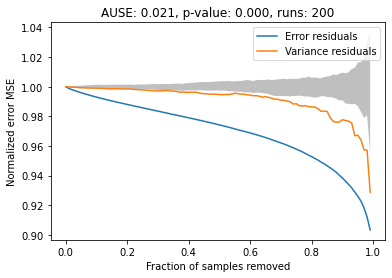

In [97]:
kernel = 'linear'
loss = 'trace_meanfield_elbo'
induced_points_method = 'random'

model = GPSparseBayesModel(**{"random_seed": 7200, 
                              "num_induced_samples": 'sqrt', 
                              "kernel": kernel,
                              "loss": loss,
                              "induced_points_method": induced_points_method
                            })
model.after_setup()
model.train(X_train, y_train)
pred_probs, pred_vars, pred_labels = model.test(X_test, None)
print("Accuracy:", accuracy_score(y_test, pred_labels), "F1 Score:", f1_score(y_test, pred_labels))
permutation_test_ause(pred_probs, pred_vars, y_test)

In [ ]:
n_estimator=10
max_sample=0.9

pipeline = Pipeline([('scale', StandardScaler()), ('svc', SVC(probability=True))])
model = BaggingClassifier(base_estimator=pipeline, n_estimators=n_estimator, max_samples=max_sample)

model.fit(X_train, y_train)

y_preds = model.predict(X_test)
y_probs = model.predict_proba(X_test)

probs = pd.DataFrame()
i = 1
for mod in model.estimators_:
    probs1 = mod.predict_proba(X_test)[:, 1] # probabilities of input being classified as 1
    probs[f'mod{i}'] = probs1
    i+=1

var_predictions = probs.var(axis=1).ravel()

accuracy = accuracy_score(y_test, y_preds)
f1 = f1_score(y_test,y_preds)
ece = expected_calibration_error(y_test, y_probs)
pred_ause = ause(y_probs[:,1].ravel(), var_predictions, y_test.ravel())[0]

print("Accuracy:", accuracy, 
      "F1 Score:", f1, 
      "ECE:", ece)
permutation_test_ause(y_probs[:,1].ravel(), var_predictions, y_test.ravel())

In [106]:
from scipy.stats import kendalltau, ttest_ind

kendalltau(pred_vars1, pred_vars2)

KendalltauResult(correlation=0.4442584114085581, pvalue=7.075244654195698e-79)

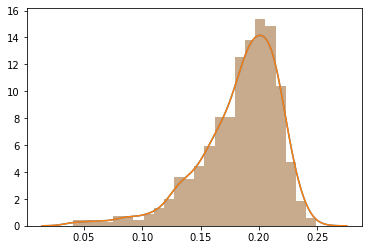

In [105]:
sns.distplot(pred_vars)
sns.distplot(pred_vars2)

In [109]:
ttest_ind(pred_vars2, pred_vars2)

Ttest_indResult(statistic=0.0, pvalue=1.0)